In [8]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')
df['gravité_accident'] = df['gravité_accident']-2
df.gravité_accident.value_counts()
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273226 entries, 0 to 273225
Data columns (total 62 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Num_Acc                             273226 non-null  int64 
 1   jour                                273226 non-null  int64 
 2   mois                                273226 non-null  int64 
 3   an                                  273226 non-null  int64 
 4   hrmn                                273226 non-null  object
 5   dep                                 273226 non-null  object
 6   agg                                 273226 non-null  int64 
 7   int                                 273226 non-null  int64 
 8   atm                                 273226 non-null  object
 9   col                                 273226 non-null  int64 
 10  lat                                 273226 non-null  object
 11  long         

In [9]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC  # Utilisation de SVM
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as imPipeline  # Utilisation d'un pipeline d'imblearn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV

SVM

Accuracy du modèle SVC : 0.70
Précision : 0.65
Rappel : 0.70
F1-score : 0.67

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.74      0.91      0.81     35156
           1       0.57      0.40      0.47     16400
           2       0.00      0.00      0.00      3090

    accuracy                           0.70     54646
   macro avg       0.44      0.44      0.43     54646
weighted avg       0.65      0.70      0.67     54646



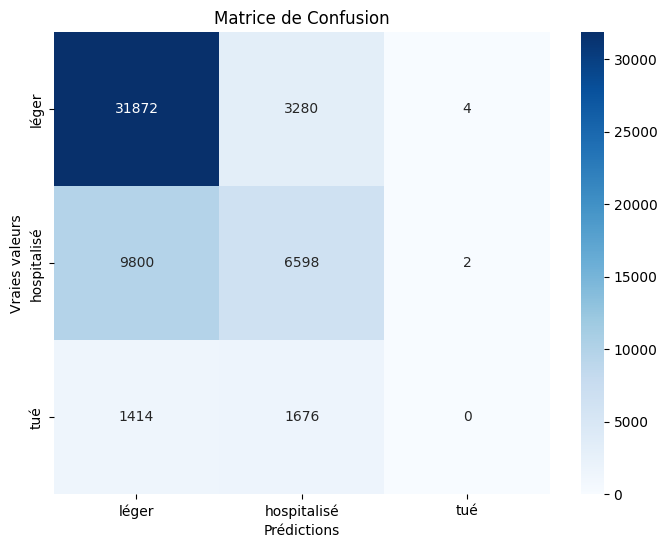

In [12]:

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features),('num', StandardScaler(), passthrough_features)])

# Définir la pipeline complète avec LinearSVC
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(C=1.0, max_iter=10000, random_state=42))
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle SVC : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['léger', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


Optimisation des paramètres du modèle et détermination de l'efficacité de la class_weight pour gérer le déséquilibre des classes

In [ ]:

# Préparation des données
X = df.drop(['Num_Acc', 'lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué', 'blessé_léger','indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Définition de la classe pour la transformation de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos


# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma','nationale_departementale_communale', 'autoroute', 'autre_route',
       'sens_unique', 'bidirectionnel', 'route_seche',
       'route_mouillee_enneigee', 'etat_route_autre', 'usager_count',
        'total_sans_secu', 'total_ceinture', 'total_casque',
       'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
       'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV',
       'pax_AR', 'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17',
       '18-60', '61-95', 'obstacle_fixe', 'obstacle_mobile', 'aucun_choc',
       'choc_AV', 'choc_AR', 'choc_cote', 'choc_tonneaux', 'VL_VU',
       '2roues_3roues_quad', 'PL', 'bus_car', 'velo_trott_edp', 'nbr_veh']  # À laisser inchangées

# Appliquer le ColumnTransformer avec `remainder='passthrough'`
preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features),('num', StandardScaler(), passthrough_features)])


# Définir la pipeline de base avec LinearSVC
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Transformation des variables
    ('classifier', LinearSVC(random_state=42, class_weight='balanced'))  # Modèle LinearSVC avec équilibrage des classes
])

# Définir la grille de recherche pour SVC
param_grid = {
   'classifier__C': [0.01, 0.1, 1, 10, 100],  # Régularisation
    'classifier__tol': [1e-4, 1e-3, 1e-2],  # Tolérance
    'classifier__loss': ['hinge', 'squared_hinge'],  # Type de fonction de perte
    'classifier__class_weight': [None, 'balanced']  # Comparer avec et sans class_weight
}

# Lancer la recherche en grille
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy', refit=True)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Prédictions
y_pred = grid_search.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy du modèle : {accuracy:.2f}")

# Précision, Rappel, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Rapport de classification
class_report = classification_report(y_test, y_pred)

# Afficher les résultats détaillés
print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"F1-score : {f1:.2f}")
print("\nRapport de Classification :")
print(class_report)

# Matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['léger', 'hospitalisé', 'tué'], yticklabels=['blessé', 'hospitalisé', 'tué'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()


Fitting 5 folds for each of 60 candidates, totalling 300 fits
